# Resampling

In [1]:
%matplotlib inline

In [2]:
import csv
import astropy.io.fits as fits
import random
from collections import defaultdict
import numpy as np
import h5py
import matplotlib.pyplot as plt
import spectraldl.utils as utils
import spectraldl.ondrejov as ondrejov
import spectraldl.lamost as lamost
import spectraldl.preprocessing as preprocessing

In [3]:
with open('data/cross-matched.csv', newline='') as f:
    paths = [tuple(row) for row in csv.reader(f)]

In [4]:
def read_spectra(paths):
    spectra = {}
    for ond_path, lam_path in paths:
        with fits.open(ond_path) as ond_hdulist:
            name = ondrejov.get_object_name(ond_hdulist)
            ond_waves, ond_fluxes = utils.cut_spectrum(
                *ondrejov.get_spectrum(ond_hdulist),
                preprocessing.START, preprocessing.END
            )
        with fits.open(lam_path) as lam_hdulist:
            lam_waves, lam_fluxes = utils.cut_spectrum(
                *lamost.get_spectrum(lam_hdulist),
                preprocessing.START, preprocessing.END
            )
        spectra[name] = {
            'ond': {'waves': ond_waves, 'fluxes': ond_fluxes},
            'lam': {'waves': lam_waves, 'fluxes': lam_fluxes}
        }
    return spectra
    
spectra = read_spectra(paths)

## Sample-rate Conversion

Sample-rate conversion it the process of changing the
sampling rate of discrete signal to get new representation
of the underlying continuous signal. The sampling rate
can be either increased (upsampling) or decreased
(decimation).

In [5]:
ond_cnts = defaultdict(int)
lam_cnts = defaultdict(int)
for data in spectra.values():
    ond_cnts[len(data['ond']['waves'])] += 1
    lam_cnts[len(data['lam']['waves'])] += 1
    
ond_cnts, lam_cnts

(defaultdict(int, {829: 5, 830: 13, 922: 3, 923: 1}),
 defaultdict(int, {140: 22}))

In [6]:
# analysis of measument in range (START, END)
def cnts_baz():
    with h5py.File('data/data.hdf5') as f:
        cnts = defaultdict(int)
        for spectrum in f['spectra'].values():
            ond_waves, ond_fluxes = utils.cut_spectrum(
                spectrum[0], spectrum[1],
                preprocessing.START, preprocessing.END
            )
            cnts[ond_fluxes.shape[0]] += 1
    return cnts

cnts_baz()

defaultdict(int, {829: 1729, 830: 7490, 831: 13, 922: 2524, 923: 1579})

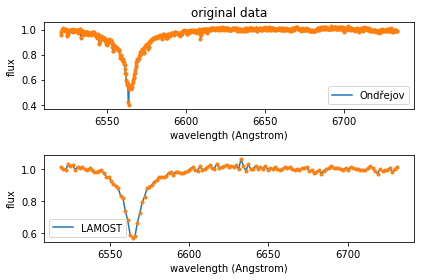

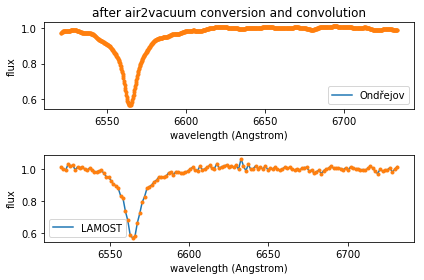

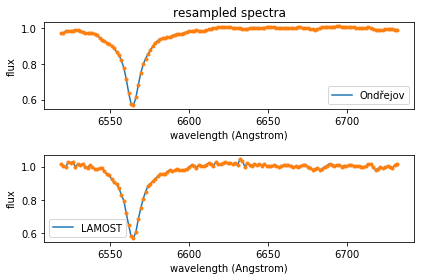

In [7]:
foo_name, foo_data = random.choice(list(spectra.items()))

def plot_foo(ond_waves, ond_fluxes, lam_waves, lam_fluxes, title):
    fig, axs = plt.subplots(2, 1)
    ax1, ax2 = axs
    
    ax1.set_title(title)
    ax1.plot(ond_waves, ond_fluxes, label='Ondřejov')
    ax1.plot(ond_waves, ond_fluxes, '.')
    
    ax2.plot(lam_waves, lam_fluxes, label='LAMOST')
    ax2.plot(lam_waves, lam_fluxes, '.')
    
    for ax in axs:
        ax.set_ylabel('flux')
        ax.set_xlabel('wavelength (Angstrom)')
        ax.legend()

    fig.tight_layout()
    
ond_vac_waves = preprocessing.air2vacuum(foo_data['ond']['waves'])

plot_foo(
    ond_vac_waves, foo_data['ond']['fluxes'],
    foo_data['lam']['waves'], foo_data['lam']['fluxes'],
    'original data'
)

ond_conv_fluxes = preprocessing.convolve_spectrum(foo_data['ond']['fluxes'])

plot_foo(
    ond_vac_waves, ond_conv_fluxes,
    foo_data['lam']['waves'], foo_data['lam']['fluxes'],
    'after air2vacuum conversion and convolution'
)

space = np.linspace(preprocessing.START, preprocessing.END, 140)
ond_resampled_fluxes = np.interp(space, ond_vac_waves, ond_conv_fluxes)
lam_resampled_fluxes = np.interp(space, foo_data['lam']['waves'], foo_data['lam']['fluxes'])

plot_foo(
    space, ond_resampled_fluxes,
    space, lam_resampled_fluxes,
    'resampled spectra'
)

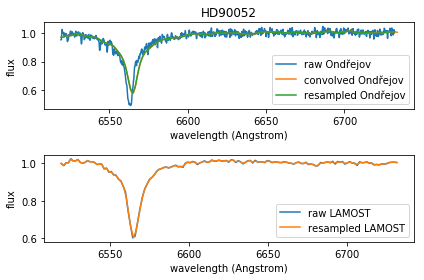

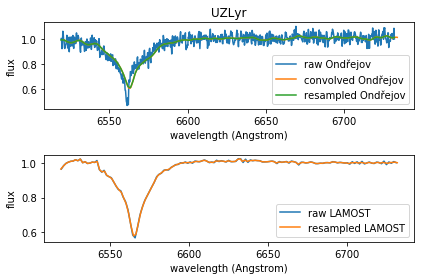

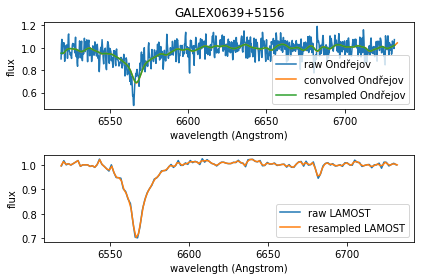

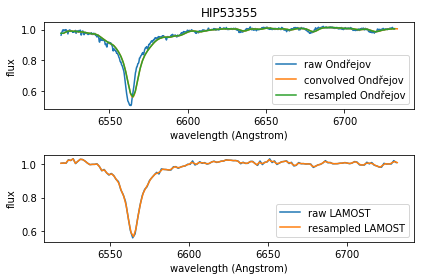

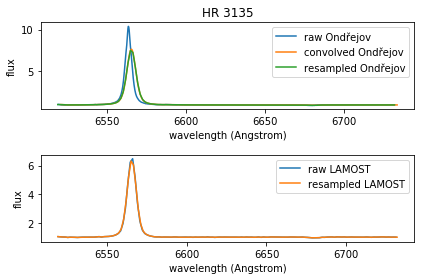

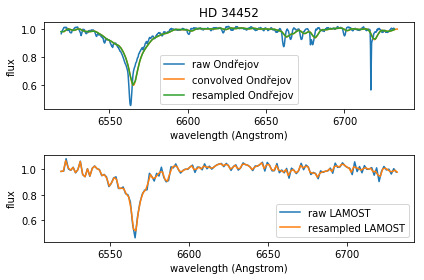

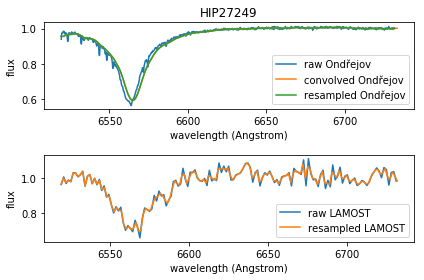

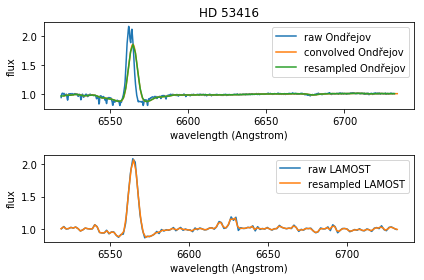

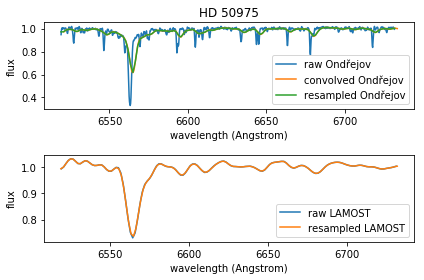

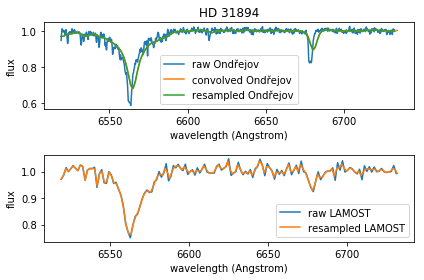

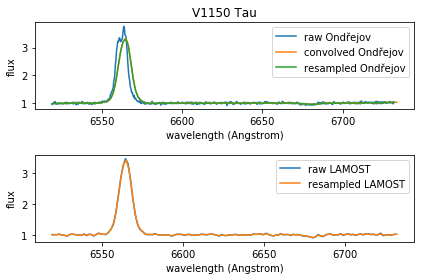

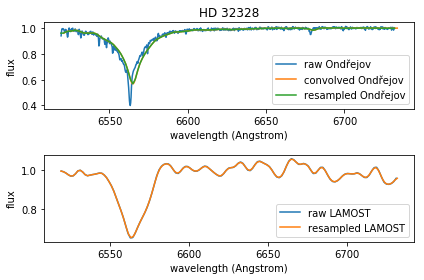

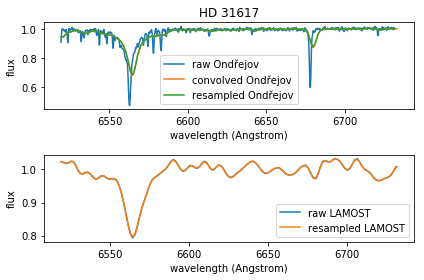

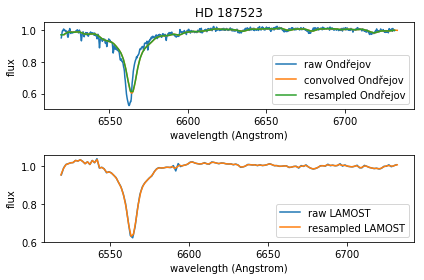

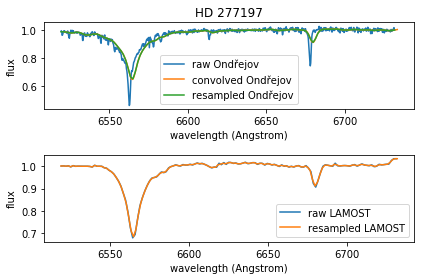

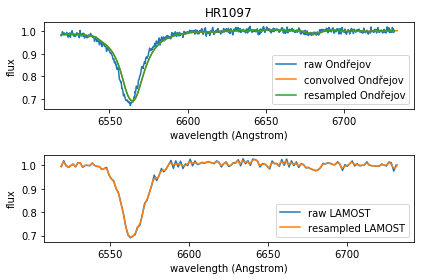

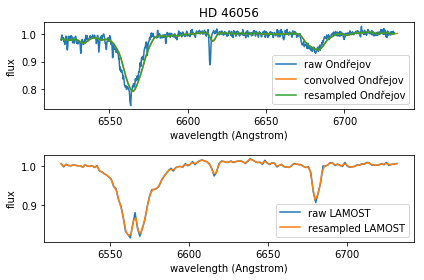

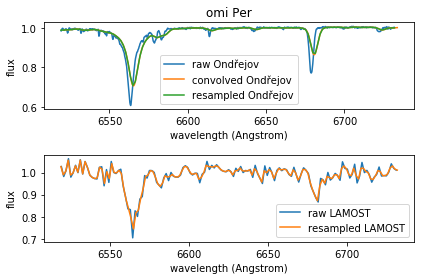

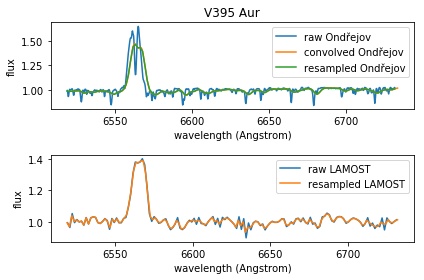

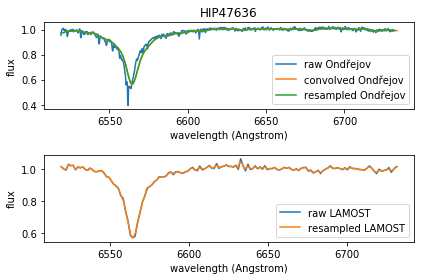

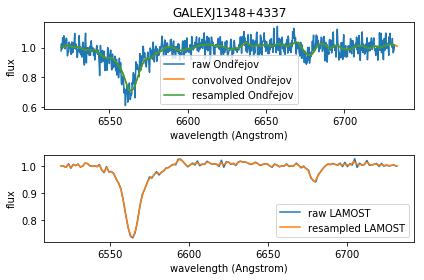

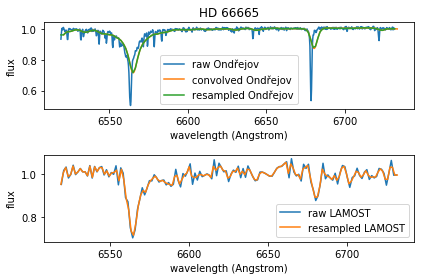

In [8]:
def plot_baz(name, data):
    fig, axs = plt.subplots(2, 1)
    ax1, ax2 = axs
    ax1.set_title(name)
    
    
    ond_waves = preprocessing.air2vacuum(data['ond']['waves'])
    ond_conv_fluxes = preprocessing.convolve_spectrum(data['ond']['fluxes'])
    ond_resampled_fluxes = preprocessing.resample_spectrum(
        ond_waves, ond_conv_fluxes, space=space
    )
    
    ax1.plot(data['ond']['waves'], data['ond']['fluxes'], label='raw Ondřejov')
    ax1.plot(ond_waves, ond_conv_fluxes, label='convolved Ondřejov')
    ax1.plot(space, ond_resampled_fluxes, label='resampled Ondřejov')
    
    lam_resampled_fluxes = preprocessing.resample_spectrum(
        data['lam']['waves'], data['lam']['fluxes'], space=space
    )
    ax2.plot(data['lam']['waves'], data['lam']['fluxes'], label='raw LAMOST')
    ax2.plot(space, lam_resampled_fluxes, label='resampled LAMOST')
    
    for ax in axs:
        ax.set_ylabel('flux')
        ax.set_xlabel('wavelength (Angstrom)')
        ax.legend()
    
    fig.tight_layout()
    plt.show()

for name, data in spectra.items():
    plot_baz(name, data)